In [1]:
import torch
import torchvision as tv
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(0)


In [3]:
train_dataset = tv.datasets.MNIST("./data", train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset = tv.datasets.MNIST("./data", train=False, transform=tv.transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


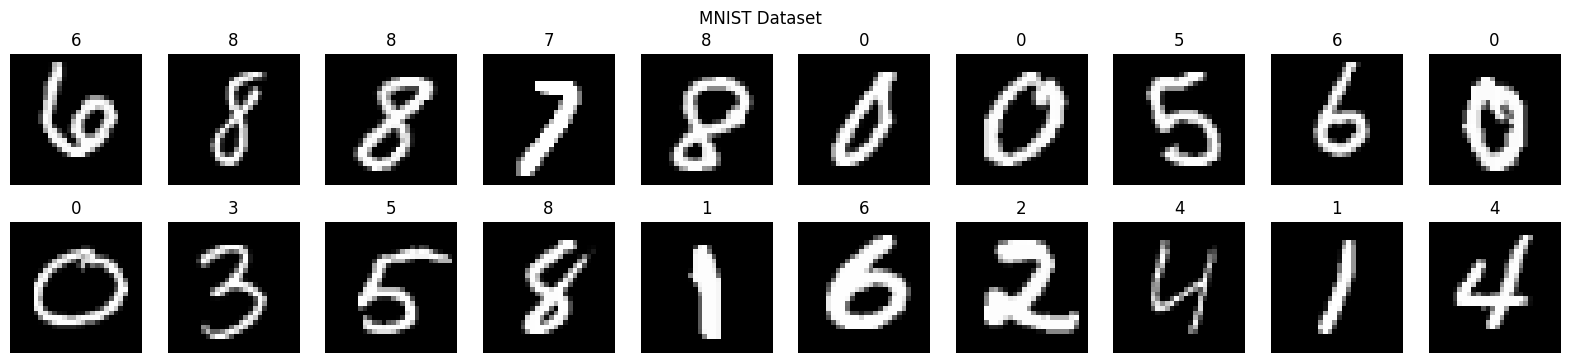

In [4]:
x, y = next(iter(train_loader))

plt.figure(figsize=(20, 4))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(x[i].numpy().squeeze(), cmap='gray')
    plt.title(y[i].item())
    plt.axis('off')
    
plt.suptitle("MNIST Dataset")
plt.show()


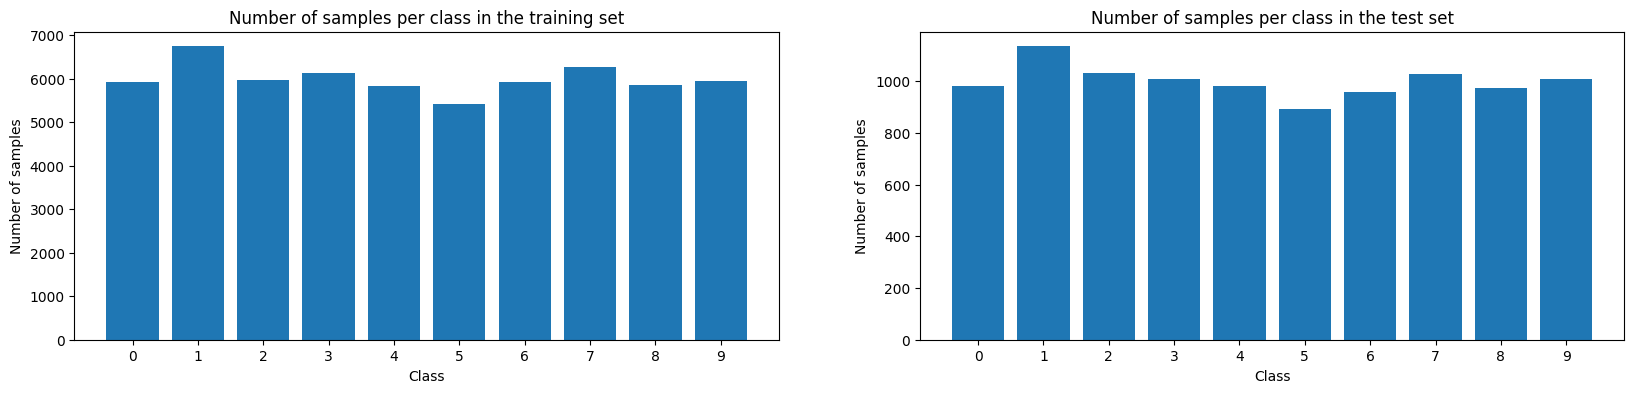

In [5]:
# Bar chart of the number of samples per class
plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.bar(*torch.unique(train_dataset.targets, return_counts=True))

# Plot labels
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Number of samples")

plt.title("Number of samples per class in the training set")

plt.subplot(1, 2, 2)
plt.bar(*torch.unique(test_dataset.targets, return_counts=True))

# Plot labels
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Number of samples")

plt.title("Number of samples per class in the test set")

plt.show()


In [6]:
# We expect a random classifier to have an accuracy of 1/10 = 0.1
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0

    for x, y in loader:
        with torch.no_grad():
            y_pred = model(x)
            correct += (y_pred.argmax(1) == y).sum().item()
            total += y.size(0)

    return correct / total



random_classifier = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 10)
)
print("Random classifier accuracy on the training set:", evaluate_model(random_classifier, train_loader))


Random classifier accuracy on the training set: 0.09126666666666666


In [7]:
def backward(loss, model, lr=0.1):
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for parameter in model.parameters():
            parameter -= lr * parameter.grad
            
def train_model(model, train_loader, test_loader, epochs=10, lr=0.1):
    train_accuracies = []
    test_accuracies = []
    loss_fn = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        for x, y in train_loader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            backward(loss, model, lr=lr)
            
        train_accuracies.append(evaluate_model(model, train_loader))
        test_accuracies.append(evaluate_model(model, test_loader))
        
    return train_accuracies, test_accuracies


In [8]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 10)
)

train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, epochs=10, lr=0.1)

print("Final training accuracy:", train_accuracies[-1])
print("Final test accuracy:", test_accuracies[-1])


  0%|          | 0/10 [00:00<?, ?it/s]

Final training accuracy: 0.9250333333333334
Final test accuracy: 0.9244


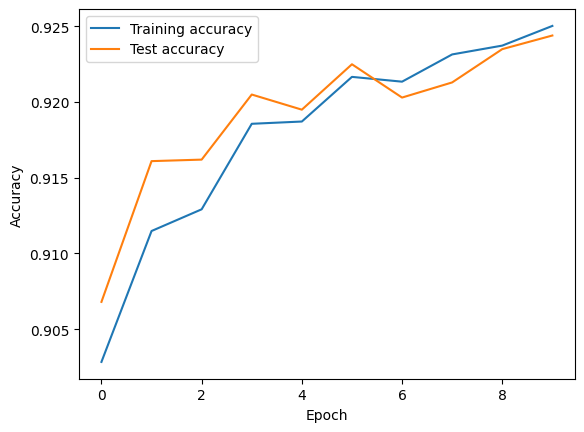

In [9]:
# YAY! We have a model that works! Let's plot the training and test accuracies
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
# Now let's make a more complex model
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10)
)


In [11]:
train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, epochs=10, lr=0.1)

print("Final training accuracy:", train_accuracies[-1])
print("Final test accuracy:", test_accuracies[-1])


  0%|          | 0/10 [00:00<?, ?it/s]

Final training accuracy: 0.9857333333333334
Final test accuracy: 0.9757


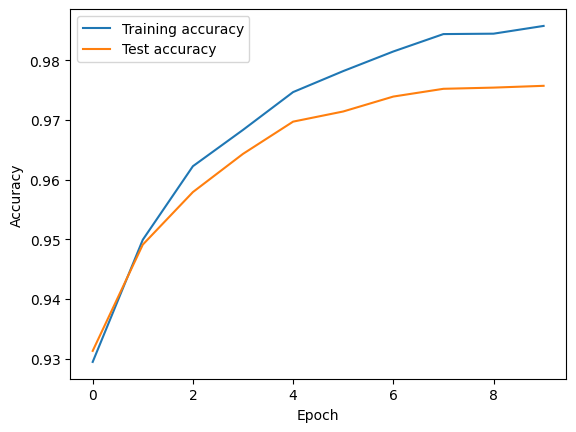

In [12]:
# Lets plot the training and test accuracies
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


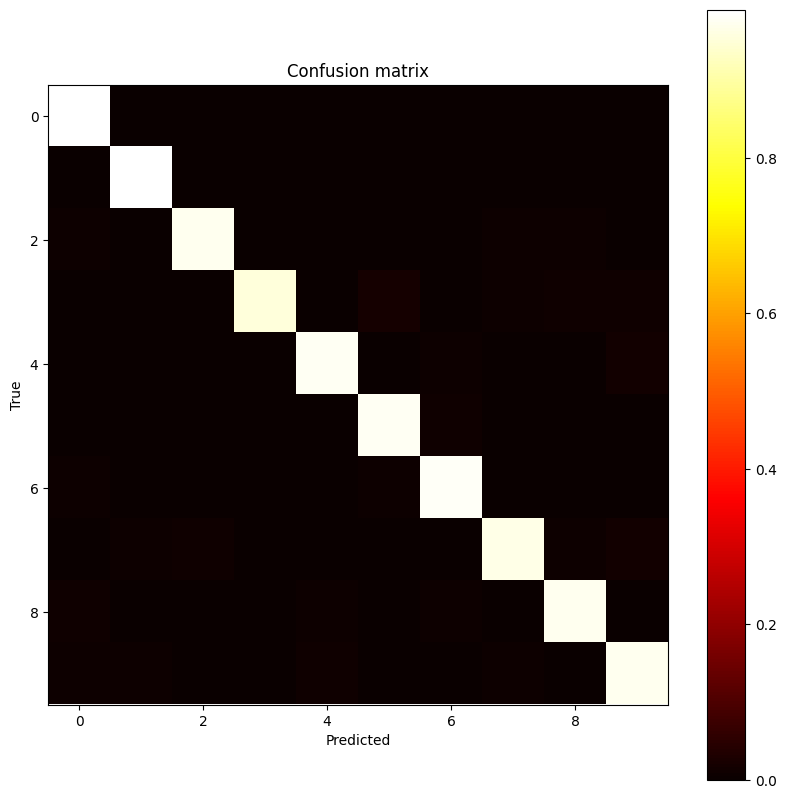

In [13]:
# Confusion matrix
model.eval()
confusion_matrix = torch.zeros(10, 10)
for x, y in test_loader:
    with torch.no_grad():
        y_pred = model(x).argmax(1)
        for i, j in zip(y, y_pred):
            confusion_matrix[i, j] += 1

# Normalize the confusion matrix
confusion_matrix /= confusion_matrix.sum(1, keepdim=True)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap="hot", interpolation="nearest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.colorbar()
plt.show()


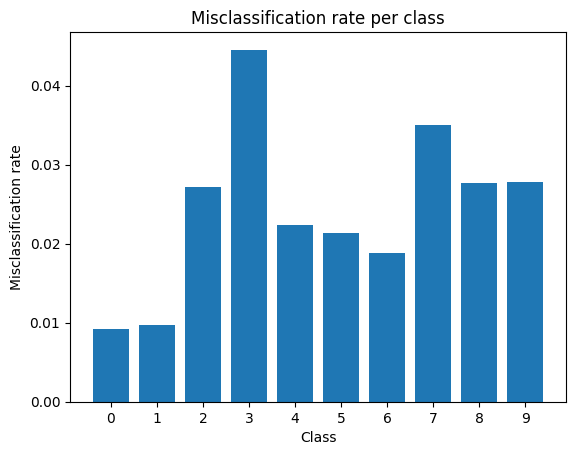

In [14]:
# But what if we want to know the accuracy per class?
class_accuracies = confusion_matrix.diag().numpy()
plt.bar(range(10), abs(class_accuracies-1))
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Misclassification rate")
plt.title("Misclassification rate per class")
plt.show()


In [15]:
# BUT WAIT! Our model is pretty big! lets see how big our model is and how much memory it uses
print(f"Model size: {sum(parameter.numel() for parameter in model.parameters()):,} parameters")
print(f"Model memory: {sum(parameter.numel() * parameter.element_size() for parameter in model.parameters()):,} bytes")


Model size: 203,530 parameters
Model memory: 814,120 bytes


In [16]:
# While this is not a lot of memory, we can make it smaller by using some techniques like convolutional neural networks
# Lets try a LeNet model
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(6, 16, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    torch.nn.Linear(16*4*4, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)

train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, epochs=10, lr=0.1)
print("Final training accuracy:", train_accuracies[-1])
print("Final test accuracy:", test_accuracies[-1])


  0%|          | 0/10 [00:00<?, ?it/s]

Final training accuracy: 0.9957333333333334
Final test accuracy: 0.9877


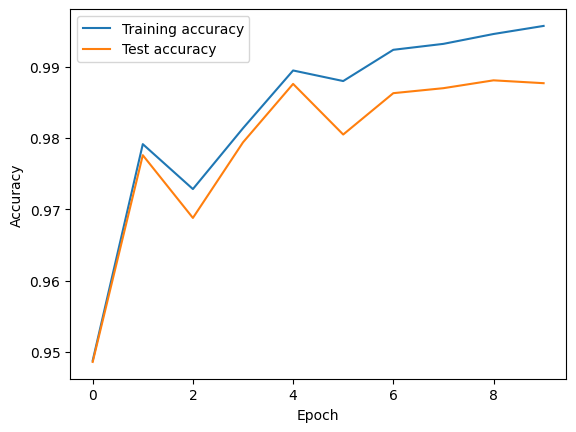

In [17]:
# Lets plot the training and test accuracies
plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


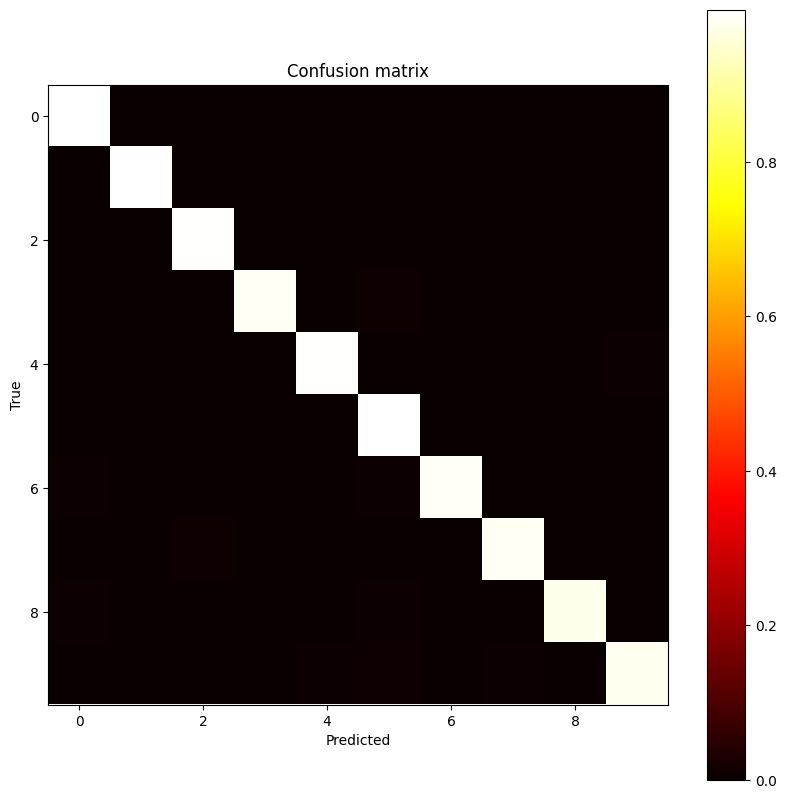

In [18]:
# Confusion matrix
model.eval()
confusion_matrix = torch.zeros(10, 10)
for x, y in test_loader:
    with torch.no_grad():
        y_pred = model(x).argmax(1)
        for i, j in zip(y, y_pred):
            confusion_matrix[i, j] += 1

# Normalize the confusion matrix
confusion_matrix /= confusion_matrix.sum(1, keepdim=True)


# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix, cmap="hot", interpolation="nearest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.colorbar()
plt.show()


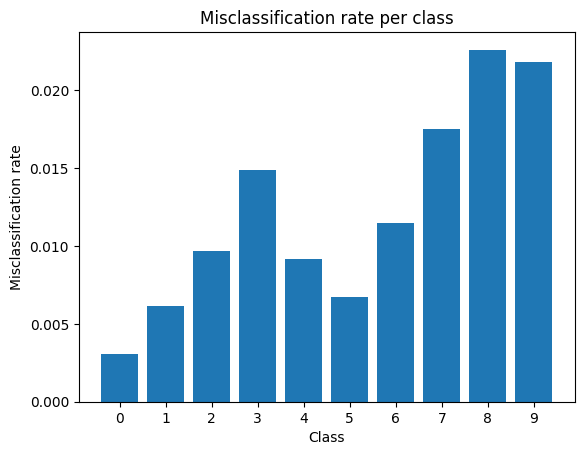

In [19]:
# But what if we want to know the accuracy per class?
class_accuracies = confusion_matrix.diag().numpy()
plt.bar(range(10), abs(class_accuracies-1))
plt.xticks(range(10))
plt.xlabel("Class")
plt.ylabel("Misclassification rate")
plt.title("Misclassification rate per class")
plt.show()


In [20]:
# Lets see how big our model is and how much memory it uses
print(f"Model size: {sum(parameter.numel() for parameter in model.parameters()):,} parameters")
print(f"Model memory: {sum(parameter.numel() * parameter.element_size() for parameter in model.parameters()):,} bytes")


Model size: 44,426 parameters
Model memory: 177,704 bytes


In [21]:
# Wow! Our model is much smaller now! And it works better!
# while we can try to make our model better by using more complex models, This is a good place to stop
# since any further improvements will be marginal and will require a lot of computational power
# and lead to the model memorizing the training data instead of generalizing

# We can see that the LeNet model is much smaller and more accurate than the linear model
# but it is also more complex and requires more computational power to train and evaluate
# this is the true tradeoff of machine learning, we can make our models more accurate but at the cost of complexity


In [22]:
# Lets also save it to disk so we can use it later
torch.save(model, "mnist_model.pth")
